In [1]:
# we are working in colab with the datasets saved in google drive.
# if you are interested in working locally, just place the datasets from 
# github into a local directory and change the corresponding path in the code.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DL Project notebook

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import imageio
import time
import os
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# helper function for transfer learning
def set_parameter_requires_grad(model, feature_extracting=False):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True

In [4]:
# helper function to load a popular architecture(we will be using VGG for our project)
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0  # image size, e.g. (3, 128, 128)

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes) # replace the last FC layer
        input_size = 128

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 128

    elif model_name == "vgg":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 128

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 128

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 128

    else:
        raise NotImplementedError

    return model_ft, input_size

In [5]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we fine-tune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

Note: If you wish to experiment with transfer learning, set use_pretrained to 'True'.

In [6]:
# Initialize the model for this run 
# You can set use_pretrained=True to use a pretrained model
model_orig, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False) # we fully train the model(just use the arch for 2 classes)

# Print the model we just instantiated
print(model_orig)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# Data resize and normalization for training and test (can also be saved for training the GAN)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# fetch the data from drive (change to local if interested)
data_dir = '/content/drive/MyDrive/datasets/IceCreamVsWaffles'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=1) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [8]:
# used to visualize the images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5, 8))
    ax = fig.add_subplot(111)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_axis_off()

In [9]:
# used to save the images
def imsave(inp,name = 'filename'):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp*255).astype(np.uint8)
    #print(inp.shape)
    imageio.imwrite('%s.png' %name, inp)


The next cell is important, as it allows us to save the normalized and cropped training data as input to the GAN.

In [10]:
# save normalized and resized images for gan training (set need_save to true to save)

need_save = False
if need_save:
    save_path_ice_cream = '/content/drive/MyDrive/datasets/gan_train_ice_cream'
    save_path_waffles = '/content/drive/MyDrive/datasets/gan_train_waffles'
    ic_idx = 0
    wf_idx = 0
    name = ''
    iterator = iter(dataloaders['train'])
    for i in range(1,dataset_sizes['train']):
        inputs, classes = next(iterator)
        #print(classes)
        if classes == 0:
            name = "{0}/ic_{1}".format(save_path_ice_cream, ic_idx) 
            imsave(inputs.reshape(3,128,128),name)
            ic_idx = ic_idx + 1
        if classes == 1:
            name = "{0}/wf_{1}".format(save_path_waffles, wf_idx) 
            imsave(inputs.reshape(3,128,128),name)
            wf_idx = wf_idx + 1

# save cropped and normalized images to path

After saving the images we can train the GAN(not in Colab):
<pre><code># convert data to standard format
python dataset_tool.py --source=./saved_images_dir --dest=./gan_in
# train model for kimg=1000 (kimg parameter effectively controls training time and quality)
python train.py --outdir=./trained_gan --data=./gan_in --kimg=1000
# generate 1000 random images from the trained latent space
python generate.py --outdir=generated_out --network=./trained_gan --seed=1-1000
</code></pre>
notes:

./saved_images_dir - should contain the images saved after crop and normalization by pytorch (set need_save=True in this notebook and specify path).

./generated_out - will contain 1000 new artificially generated images.

after generating seperate images for both classes you can merge them with the original training data to create the modified dataset for the second classifier.

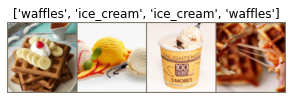

In [11]:
# Let’s visualize a few training images .
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from first 4 images in batch and show 
out = torchvision.utils.make_grid(inputs[1:5])

imshow(out, title=[class_names[x] for x in classes[1:5]])

In [12]:
# split train set to train-val
# we use 20% of train data for validation

validation_split = .2
shuffle_dataset = True
random_seed= 42
indices = list(range(dataset_sizes['train']))
split = int(np.floor(validation_split * dataset_sizes['train']))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
data_size = {'train' : 0, 'valid' : 0, 'test' : 0}
data_size['train'] = len(train_sampler)
data_size['valid'] = len(valid_sampler)
data_size['test'] = len(dataloaders['test'])

# modifying train and adding validation entry to dataloaders:
dataloaders['train'] = DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler)
dataloaders['valid'] = DataLoader(image_datasets['train'], batch_size=batch_size, sampler=valid_sampler) 

In [13]:
# send original model to device
model_orig = model_orig.to(device)
''' only relevant for transfer learning '''
# Gather the parameters to be optimized/updated in this run. If we are
#  fine-tuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_orig.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_orig.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_orig.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [14]:
"""
Training function
"""
def train_model(model, dataloaders, criterion, optimizer, data_size, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [15]:
# Setup the loss fn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
torch.cuda.empty_cache()
model_orig, hist_orig = train_model(model_orig, dataloaders, criterion, optimizer_ft, data_size=data_size, num_epochs=num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6915 Acc: 0.5250
valid Loss: 0.6914 Acc: 0.4790

Epoch 1/14
----------
train Loss: 0.6863 Acc: 0.5646
valid Loss: 0.6848 Acc: 0.4790

Epoch 2/14
----------
train Loss: 0.6832 Acc: 0.5333
valid Loss: 0.6725 Acc: 0.5462

Epoch 3/14
----------
train Loss: 0.6705 Acc: 0.6125
valid Loss: 0.6482 Acc: 0.7563

Epoch 4/14
----------
train Loss: 0.6464 Acc: 0.6604
valid Loss: 0.6050 Acc: 0.7899

Epoch 5/14
----------
train Loss: 0.6057 Acc: 0.7438
valid Loss: 0.5344 Acc: 0.7563

Epoch 6/14
----------
train Loss: 0.5202 Acc: 0.7688
valid Loss: 0.4534 Acc: 0.7983

Epoch 7/14
----------
train Loss: 0.4762 Acc: 0.7937
valid Loss: 0.4833 Acc: 0.7647

Epoch 8/14
----------
train Loss: 0.5526 Acc: 0.7438
valid Loss: 0.6198 Acc: 0.6723

Epoch 9/14
----------
train Loss: 0.5966 Acc: 0.6687
valid Loss: 0.5649 Acc: 0.7227

Epoch 10/14
----------
train Loss: 0.5143 Acc: 0.7750
valid Loss: 0.4513 Acc: 0.7563

Epoch 11/14
----------
train Loss: 0.4596 Acc: 0.8000
valid Loss: 0.4073 Acc: 0.8319



Now we shall train an identical model using the GAN enriched training set (300+1000 training samples for each class).

In [16]:
# Instantiate new model
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we fine-tune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False 
# Initialize the model for this run
model_gan, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False) # we fully train the model(just use the arch for 2 classes)


In [17]:
# Fetch GAN enriched dataset 
# here you specify the path to the enriched dataset
data_dir_gan = '/content/drive/MyDrive/datasets/dataset_gan_enriched_v2'
image_datasets_gan = {x: ImageFolder(os.path.join(data_dir_gan, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders_gan = {x: DataLoader(image_datasets_gan[x], batch_size=batch_size,
                             shuffle=True) for x in ['train', 'test']}
dataset_sizes_gan = {x: len(image_datasets_gan[x]) for x in ['train', 'test']}
class_names_gan = image_datasets_gan['train'].classes

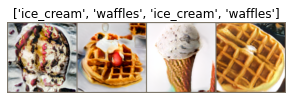

In [18]:
# Let’s visualize a few training images (notice the GAN generated images)
# Get a batch of training data
inputs, classes = next(iter(dataloaders_gan['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[1:5])

imshow(out, title=[class_names_gan[x] for x in classes[1:5]])

In [19]:
# further split train set to train-val


validation_split = .2
shuffle_dataset = True
random_seed= 42
indices = list(range(dataset_sizes_gan['train']))
split = int(np.floor(validation_split * dataset_sizes_gan['train']))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
data_size_gan = {'train' : 0, 'valid' : 0, 'test' : 0}
data_size_gan['train'] = len(train_sampler)
data_size_gan['valid'] = len(valid_sampler)
data_size_gan['test'] = len(dataloaders['test'])
# modifying train and adding validation entry to dataloaders(effectively splitting trainset to train-val):
dataloaders_gan['train'] = DataLoader(image_datasets_gan['train'], batch_size=batch_size, sampler=train_sampler)
dataloaders_gan['valid'] = DataLoader(image_datasets_gan['train'], batch_size=batch_size, sampler=valid_sampler) 

In [20]:
model_gan = model_gan.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  fine-tuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_gan.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_gan.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_gan.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_gan = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [21]:
# Setup the loss fn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_gan, hist_gan = train_model(model_gan, dataloaders_gan, criterion, optimizer_gan, data_size=data_size_gan, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.6600 Acc: 0.5924
valid Loss: 0.5139 Acc: 0.8096

Epoch 1/14
----------
train Loss: 0.4000 Acc: 0.8351
valid Loss: 0.2919 Acc: 0.8825

Epoch 2/14
----------
train Loss: 0.2427 Acc: 0.9000
valid Loss: 0.2281 Acc: 0.9053

Epoch 3/14
----------
train Loss: 0.2294 Acc: 0.9109
valid Loss: 0.1665 Acc: 0.9325

Epoch 4/14
----------
train Loss: 0.1576 Acc: 0.9410
valid Loss: 0.0817 Acc: 0.9728

Epoch 5/14
----------
train Loss: 0.1549 Acc: 0.9402
valid Loss: 0.0822 Acc: 0.9804

Epoch 6/14
----------
train Loss: 0.0997 Acc: 0.9652
valid Loss: 0.0554 Acc: 0.9848

Epoch 7/14
----------
train Loss: 0.1011 Acc: 0.9652
valid Loss: 0.0614 Acc: 0.9848

Epoch 8/14
----------
train Loss: 0.0881 Acc: 0.9696
valid Loss: 0.0652 Acc: 0.9782

Epoch 9/14
----------
train Loss: 0.0770 Acc: 0.9726
valid Loss: 0.0466 Acc: 0.9859

Epoch 10/14
----------
train Loss: 0.0576 Acc: 0.9785
valid Loss: 0.0458 Acc: 0.9880

Epoch 11/14
----------
train Loss: 0.0858 Acc: 0.9723
valid Loss

Finally compare the models on test accuracy:

In [22]:

running_loss_orig = 0.0
running_corrects_orig = 0
running_loss_gan = 0.0
running_corrects_gan = 0

#iterate over test
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        # Get model outputs and calculate loss
        outputs_orig = model_orig(inputs)
        outputs_gan = model_gan(inputs)
        loss_orig = criterion(outputs_orig, labels)
        loss_gan = criterion(outputs_gan, labels)

        _, preds_orig = torch.max(outputs_orig, 1)
        _, preds_gan = torch.max(outputs_gan, 1)

    # statistics
    running_loss_orig += loss_orig.item() * inputs.size(0)
    running_corrects_orig += torch.sum(preds_orig == labels.data)

    running_loss_gan += loss_gan.item() * inputs.size(0)
    running_corrects_gan += torch.sum(preds_gan == labels.data)

epoch_loss_orig = running_loss_orig / len(dataloaders['test'].dataset)
epoch_acc_orig = running_corrects_orig.double() / len(dataloaders['test'].dataset)

epoch_loss_gan = running_loss_gan / len(dataloaders['test'].dataset)
epoch_acc_gan = running_corrects_gan.double() / len(dataloaders['test'].dataset)

print('Original {} Loss: {:.4f} Original Acc: {:.4f}'.format('test', epoch_loss_orig, epoch_acc_orig))
print('GAN enriched {} Loss: {:.4f} GAN enriched Acc: {:.4f}'.format('test', epoch_loss_gan, epoch_acc_gan))

Original test Loss: 0.4199 Original Acc: 0.8163
GAN enriched test Loss: 0.2735 GAN enriched Acc: 0.8776


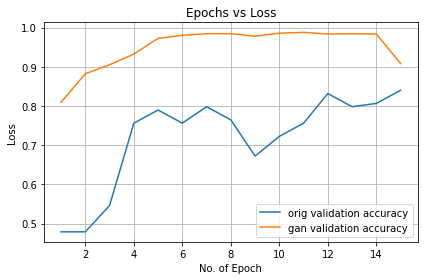

In [23]:
# plot train-val loss
plt.plot( range(1,num_epochs+1),hist_orig,label = 'orig validation accuracy')
plt.plot( range(1,num_epochs+1),hist_gan,label = 'gan validation accuracy')
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()